# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
import json
import itertools
import gc

from ResNet import ResnetBuilder

import glob
from IPython.display import clear_output

## ref

In [ ]:
import sys
from resnet_build_multi_avg_predict import ResnetBuilder

import math
import time
import datetime
import json
from tqdm import tqdm # progress bar
import gc

import tensorflow.keras

import glob
import nibabel as nib # NiBabelの導入の確認　エラーが出なければ成功
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split

import scipy as scipy
from scipy.ndimage.interpolation import zoom

from tensorflow.keras import losses
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, concatenate
from tensorflow.keras.backend import set_session
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers.advanced_activations import PReLU
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras import optimizers
#from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers
from tensorflow.keras import backend as K

import tensorflow as tf

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable

import itertools

from openpyxl.workbook import Workbook # Excel

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = train.label # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

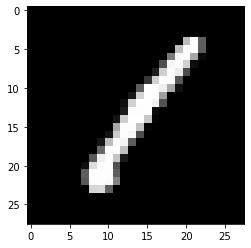

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray') #,cmap='gray',origin='lower'
plt.show()

# 3. Model Create

## 3.1 Summary

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Model Result Setting

In [5]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10" # 設定に変更があった場合ここだけ変更
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [8]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 512 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37376/37794 [============================>.] - ETA: 0s - loss: 4.8844 - acc: 0.9448
Epoch 00001: val_loss improved from inf to 7.50538, saving model to img_classifier_model_1_ResNet50_epoch10.h5
37794/37794 [==============================] - 27s 727us/sample - loss: 4.8771 - acc: 0.9452 - val_loss: 7.5054 - val_acc: 0.5516
Epoch 2/10
37376/37794 [============================>.] - ETA: 0s - loss: 3.8188 - acc: 0.9925
Epoch 00002: val_loss improved from 7.50538 to 3.58664, saving model to img_classifier_model_1_ResNet50_epoch10.h5
37794/37794 [==============================] - 14s 359us/sample - loss: 3.8154 - acc: 0.9925 - val_loss: 3.5866 - val_acc: 0.9610
Epoch 3/10
37376/37794 [============================>.] - ETA: 0s - loss: 3.2205 - acc: 0.9983
Epoch 00003: val_loss improved from 3.58664 to 3.03295, saving model to img_classifier_model_1_ResNet50_epoch10.h5
37794/37794 [==============================] - 1

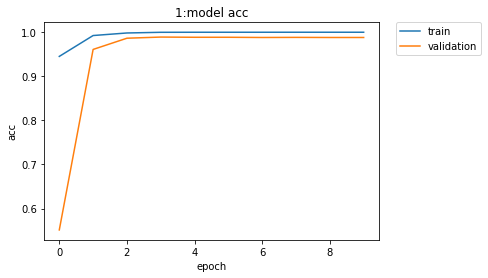

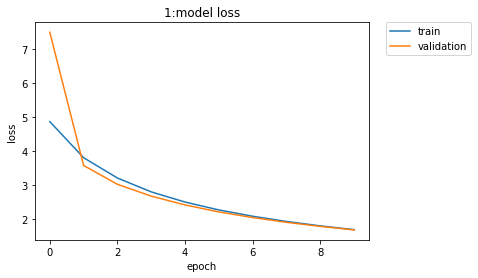

Done compiling best model.


1. Accuracy on validation data: 0.988112
Classification Report
              precision    recall  f1-score   support

           0    0.99281   1.00000   0.99639       414
           1    0.99574   0.99574   0.99574       469
           2    0.99275   0.98325   0.98798       418
           3    0.98621   0.98394   0.98507       436
           4    0.97837   0.99755   0.98786       408
           5    0.98681   0.98421   0.98551       380
           6    0.99275   0.99275   0.99275       414
           7    0.97982   0.99093   0.98534       441
           8    0.98519   0.98034   0.98276       407
           9    0.99027   0.97136   0.98072       419

   micro avg    0.98811   0.98811   0.98811      4206
   macro avg    0.98807   0.98801   0.98801      4206
weighted avg    0.98814   0.98811   0.98810      4206
 samples avg    0.98811   0.98811   0.98811      4206





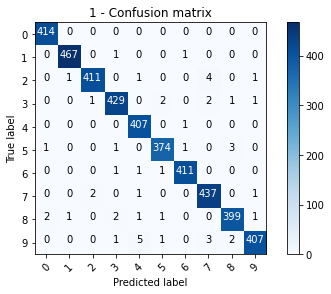

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37376/37796 [============================>.] - ETA: 0s - loss: 4.8799 - acc: 0.9424
Epoch 00001: val_loss improved from inf to 9.39255, saving model to img_classifier_model_2_ResNet50_epoch10.h5
37796/37796 [==============================] - 25s 664us/sample - loss: 4.8727 - acc: 0.9429 - val_loss: 9.3926 - val_acc: 0.4001
Epoch 2/10
37376/37796 [============================>.] - ETA: 0s - loss: 3.8315 - acc: 0.9915
Epoch 00002: val_loss improved from 9.39255 to 3.58931, saving model to img_classifier_model_2_ResNet50_epoch10.h5
37796/37796 [==============================] - 14s 362us/sample - loss: 3.8278 - acc: 0.9916 - val_loss: 3.5893 - val_acc: 0.9681
Epoch 3/10
37376/37796 [============================>.] - ETA: 0s - loss: 3.2382 - acc: 0.9983
Epoch 00003: val_loss improved from 3.58931 to 3.05908, saving model to img_classifier_model_2_ResNet50_epoch10.h5
37796/37796 [==============================] - 1

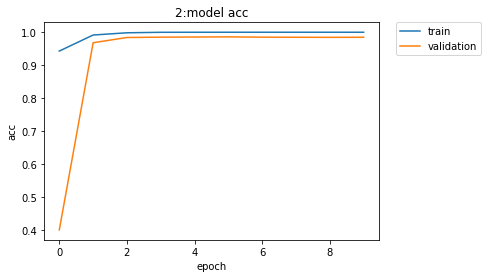

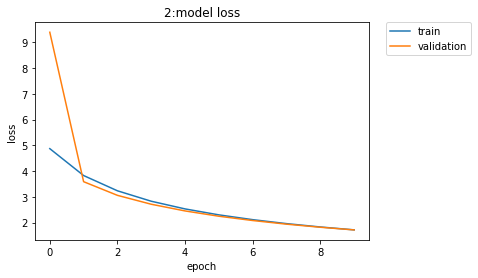

Done compiling best model.


2. Accuracy on validation data: 0.984776
Classification Report
              precision    recall  f1-score   support

           0    0.97862   0.99517   0.98683       414
           1    0.98109   0.99574   0.98836       469
           2    0.98321   0.98086   0.98204       418
           3    0.99766   0.97931   0.98840       435
           4    0.99017   0.98775   0.98896       408
           5    0.97128   0.97895   0.97510       380
           6    0.98780   0.97826   0.98301       414
           7    0.99312   0.98409   0.98858       440
           8    0.98515   0.97789   0.98150       407
           9    0.97872   0.98807   0.98337       419

   micro avg    0.98478   0.98478   0.98478      4204
   macro avg    0.98468   0.98461   0.98461      4204
weighted avg    0.98484   0.98478   0.98478      4204
 samples avg    0.98478   0.98478   0.98478      4204





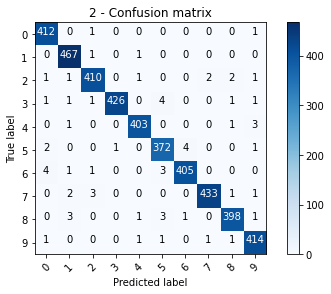

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37376/37798 [============================>.] - ETA: 0s - loss: 4.8855 - acc: 0.9428
Epoch 00001: val_loss improved from inf to 8.73940, saving model to img_classifier_model_3_ResNet50_epoch10.h5
37798/37798 [==============================] - 25s 661us/sample - loss: 4.8784 - acc: 0.9431 - val_loss: 8.7394 - val_acc: 0.5602
Epoch 2/10
37376/37798 [============================>.] - ETA: 0s - loss: 3.8377 - acc: 0.9922
Epoch 00002: val_loss improved from 8.73940 to 3.60735, saving model to img_classifier_model_3_ResNet50_epoch10.h5
37798/37798 [==============================] - 14s 368us/sample - loss: 3.8340 - acc: 0.9921 - val_loss: 3.6073 - val_acc: 0.9629
Epoch 3/10
37376/37798 [============================>.] - ETA: 0s - loss: 3.2440 - acc: 0.9988
Epoch 00003: val_loss improved from 3.60735 to 3.06390, saving model to img_classifier_model_3_ResNet50_epoch10.h5
37798/37798 [==============================] - 1

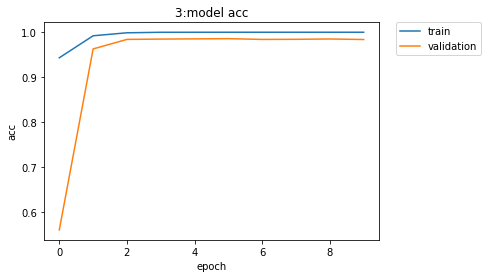

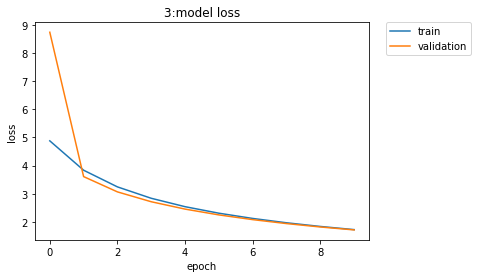

Done compiling best model.


3. Accuracy on validation data: 0.983817
Classification Report
              precision    recall  f1-score   support

           0    0.99267   0.98305   0.98783       413
           1    0.98726   0.99147   0.98936       469
           2    0.97170   0.98565   0.97862       418
           3    0.98618   0.98391   0.98504       435
           4    0.98515   0.97789   0.98150       407
           5    1.00000   0.97632   0.98802       380
           6    0.98798   0.99275   0.99036       414
           7    0.98174   0.97727   0.97950       440
           8    0.98030   0.97789   0.97909       407
           9    0.96737   0.99045   0.97877       419

   micro avg    0.98382   0.98382   0.98382      4202
   macro avg    0.98403   0.98366   0.98381      4202
weighted avg    0.98391   0.98382   0.98383      4202
 samples avg    0.98382   0.98382   0.98382      4202





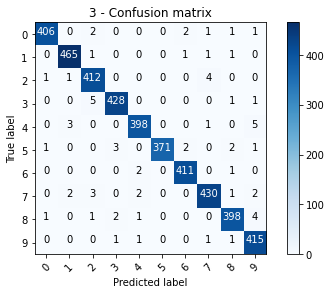

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37376/37799 [============================>.] - ETA: 0s - loss: 4.8953 - acc: 0.9430
Epoch 00001: val_loss improved from inf to 17.95568, saving model to img_classifier_model_4_ResNet50_epoch10.h5
37799/37799 [==============================] - 25s 670us/sample - loss: 4.8882 - acc: 0.9434 - val_loss: 17.9557 - val_acc: 0.2454
Epoch 2/10
37376/37799 [============================>.] - ETA: 0s - loss: 3.8555 - acc: 0.9921
Epoch 00002: val_loss improved from 17.95568 to 3.75025, saving model to img_classifier_model_4_ResNet50_epoch10.h5
37799/37799 [==============================] - 14s 372us/sample - loss: 3.8519 - acc: 0.9920 - val_loss: 3.7502 - val_acc: 0.9286
Epoch 3/10
37376/37799 [============================>.] - ETA: 0s - loss: 3.2622 - acc: 0.9988- ETA: 3s - loss: 
Epoch 00003: val_loss improved from 3.75025 to 3.08620, saving model to img_classifier_model_4_ResNet50_epoch10.h5
37799/37799 [==============

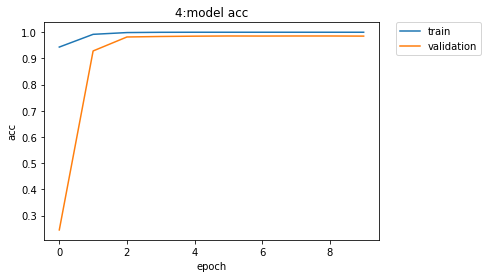

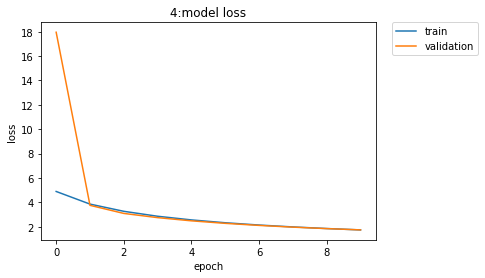

Done compiling best model.


4. Accuracy on validation data: 0.985242
Classification Report
              precision    recall  f1-score   support

           0    0.98317   0.99031   0.98673       413
           1    0.99149   0.99360   0.99255       469
           2    0.98341   0.99282   0.98810       418
           3    0.98843   0.98161   0.98501       435
           4    0.99261   0.99017   0.99139       407
           5    0.98670   0.97632   0.98148       380
           6    0.99031   0.98792   0.98912       414
           7    0.97748   0.98636   0.98190       440
           8    0.97073   0.98030   0.97549       406
           9    0.98786   0.97136   0.97954       419

   micro avg    0.98524   0.98524   0.98524      4201
   macro avg    0.98522   0.98508   0.98513      4201
weighted avg    0.98528   0.98524   0.98524      4201
 samples avg    0.98524   0.98524   0.98524      4201





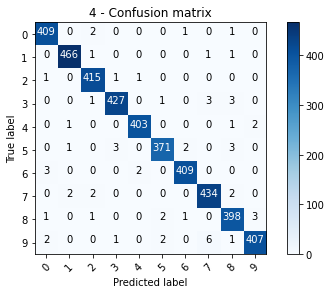

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37376/37800 [============================>.] - ETA: 0s - loss: 4.9015 - acc: 0.9445
Epoch 00001: val_loss improved from inf to 9.18614, saving model to img_classifier_model_5_ResNet50_epoch10.h5
37800/37800 [==============================] - 26s 685us/sample - loss: 4.8945 - acc: 0.9449 - val_loss: 9.1861 - val_acc: 0.5319
Epoch 2/10
37376/37800 [============================>.] - ETA: 0s - loss: 3.8830 - acc: 0.9921
Epoch 00002: val_loss improved from 9.18614 to 3.82413, saving model to img_classifier_model_5_ResNet50_epoch10.h5
37800/37800 [==============================] - 14s 367us/sample - loss: 3.8797 - acc: 0.9920 - val_loss: 3.8241 - val_acc: 0.9188
Epoch 3/10
37376/37800 [============================>.] - ETA: 0s - loss: 3.2984 - acc: 0.9984
Epoch 00003: val_loss improved from 3.82413 to 3.13201, saving model to img_classifier_model_5_ResNet50_epoch10.h5
37800/37800 [==============================] - 1

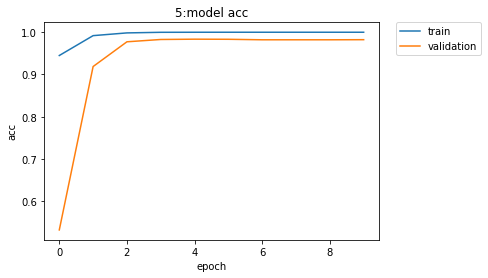

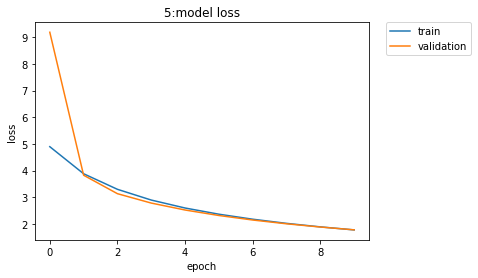

Done compiling best model.


5. Accuracy on validation data: 0.982381
Classification Report
              precision    recall  f1-score   support

           0    0.99516   0.99516   0.99516       413
           1    0.98507   0.98718   0.98613       468
           2    0.98309   0.97368   0.97837       418
           3    0.97471   0.97471   0.97471       435
           4    0.98995   0.96806   0.97888       407
           5    0.98681   0.98421   0.98551       380
           6    0.99270   0.98551   0.98909       414
           7    0.97763   0.99318   0.98534       440
           8    0.97073   0.98030   0.97549       406
           9    0.96934   0.98091   0.97509       419

   micro avg    0.98238   0.98238   0.98238      4200
   macro avg    0.98252   0.98229   0.98238      4200
weighted avg    0.98244   0.98238   0.98238      4200
 samples avg    0.98238   0.98238   0.98238      4200





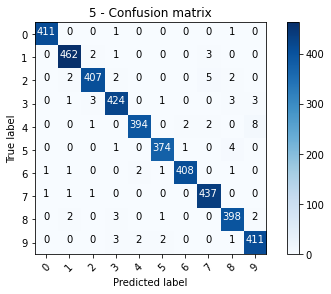

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37376/37801 [============================>.] - ETA: 0s - loss: 4.8897 - acc: 0.9439
Epoch 00001: val_loss improved from inf to 6.05884, saving model to img_classifier_model_6_ResNet50_epoch10.h5
37801/37801 [==============================] - 25s 656us/sample - loss: 4.8823 - acc: 0.9444 - val_loss: 6.0588 - val_acc: 0.7066
Epoch 2/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.8377 - acc: 0.9920
Epoch 00002: val_loss improved from 6.05884 to 3.73521, saving model to img_classifier_model_6_ResNet50_epoch10.h5
37801/37801 [==============================] - 14s 370us/sample - loss: 3.8340 - acc: 0.9920 - val_loss: 3.7352 - val_acc: 0.9255
Epoch 3/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.2429 - acc: 0.9985- ETA: 1s - loss: 3.2612 - acc: 
Epoch 00003: val_loss improved from 3.73521 to 3.06720, saving model to img_classifier_model_6_ResNet50_epoch10.h5
37801/37801 [===

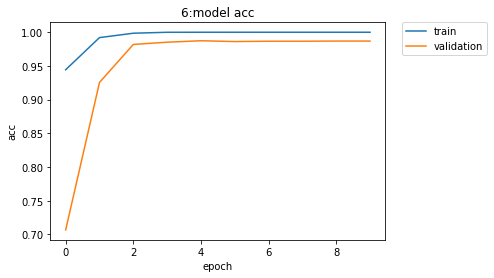

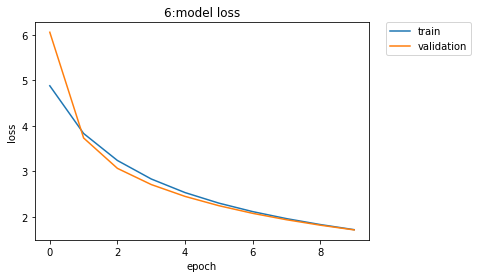

Done compiling best model.


6. Accuracy on validation data: 0.986902
Classification Report
              precision    recall  f1-score   support

           0    0.98091   0.99516   0.98798       413
           1    0.98729   0.99573   0.99149       468
           2    0.99043   0.99043   0.99043       418
           3    0.98837   0.97701   0.98266       435
           4    0.99257   0.98526   0.98890       407
           5    0.99202   0.98417   0.98808       379
           6    0.99270   0.98551   0.98909       414
           7    0.97982   0.99318   0.98646       440
           8    0.97567   0.98768   0.98164       406
           9    0.99029   0.97375   0.98195       419

   micro avg    0.98690   0.98690   0.98690      4199
   macro avg    0.98701   0.98679   0.98687      4199
weighted avg    0.98695   0.98690   0.98690      4199
 samples avg    0.98690   0.98690   0.98690      4199





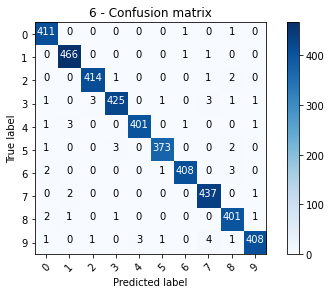

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37376/37801 [============================>.] - ETA: 0s - loss: 4.8863 - acc: 0.9444
Epoch 00001: val_loss improved from inf to 12.49335, saving model to img_classifier_model_7_ResNet50_epoch10.h5
37801/37801 [==============================] - 23s 595us/sample - loss: 4.8787 - acc: 0.9449 - val_loss: 12.4934 - val_acc: 0.3551
Epoch 2/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.8328 - acc: 0.9921
Epoch 00002: val_loss improved from 12.49335 to 3.64553, saving model to img_classifier_model_7_ResNet50_epoch10.h5
37801/37801 [==============================] - 14s 369us/sample - loss: 3.8290 - acc: 0.9922 - val_loss: 3.6455 - val_acc: 0.9455
Epoch 3/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.2343 - acc: 0.9983
Epoch 00003: val_loss improved from 3.64553 to 3.05116, saving model to img_classifier_model_7_ResNet50_epoch10.h5
37801/37801 [==============================] 

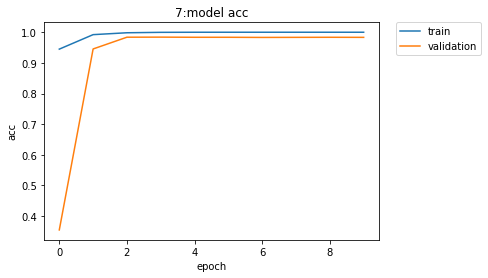

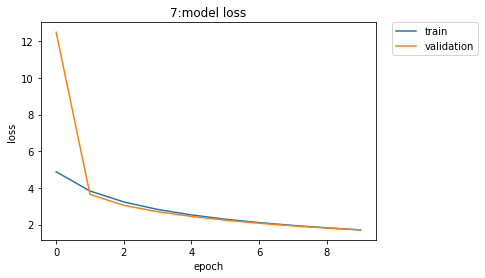

Done compiling best model.


7. Accuracy on validation data: 0.983329
Classification Report
              precision    recall  f1-score   support

           0    0.98558   0.99274   0.98914       413
           1    0.98732   0.99786   0.99256       468
           2    0.98058   0.96651   0.97349       418
           3    0.97931   0.97931   0.97931       435
           4    0.97343   0.99017   0.98173       407
           5    0.98663   0.97361   0.98008       379
           6    0.99754   0.97826   0.98780       414
           7    0.99087   0.98636   0.98861       440
           8    0.97101   0.99015   0.98049       406
           9    0.98082   0.97613   0.97847       419

   micro avg    0.98333   0.98333   0.98333      4199
   macro avg    0.98331   0.98311   0.98317      4199
weighted avg    0.98339   0.98333   0.98332      4199
 samples avg    0.98333   0.98333   0.98333      4199





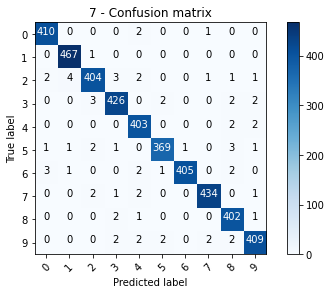

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37376/37803 [============================>.] - ETA: 0s - loss: 4.8669 - acc: 0.9435
Epoch 00001: val_loss improved from inf to 13.19604, saving model to img_classifier_model_8_ResNet50_epoch10.h5
37803/37803 [==============================] - 25s 657us/sample - loss: 4.8601 - acc: 0.9438 - val_loss: 13.1960 - val_acc: 0.2933
Epoch 2/10
37376/37803 [============================>.] - ETA: 0s - loss: 3.7975 - acc: 0.9923
Epoch 00002: val_loss improved from 13.19604 to 3.52663, saving model to img_classifier_model_8_ResNet50_epoch10.h5
37803/37803 [==============================] - 14s 368us/sample - loss: 3.7937 - acc: 0.9923 - val_loss: 3.5266 - val_acc: 0.9724
Epoch 3/10
37376/37803 [============================>.] - ETA: 0s - loss: 3.1975 - acc: 0.9981
Epoch 00003: val_loss improved from 3.52663 to 3.01196, saving model to img_classifier_model_8_ResNet50_epoch10.h5
37803/37803 [==============================] 

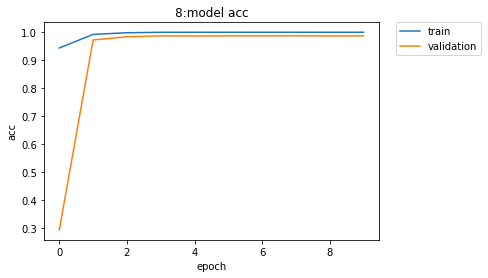

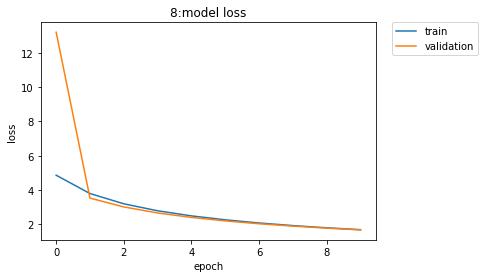

Done compiling best model.


8. Accuracy on validation data: 0.987134
Classification Report
              precision    recall  f1-score   support

           0    0.99036   0.99516   0.99275       413
           1    0.98732   0.99786   0.99256       468
           2    0.99512   0.97842   0.98670       417
           3    0.99534   0.98161   0.98843       435
           4    0.98771   0.98771   0.98771       407
           5    0.98950   0.99472   0.99211       379
           6    1.00000   0.98063   0.99022       413
           7    0.98858   0.98409   0.98633       440
           8    0.95498   0.99261   0.97343       406
           9    0.98321   0.97852   0.98086       419

   micro avg    0.98713   0.98713   0.98713      4197
   macro avg    0.98721   0.98713   0.98711      4197
weighted avg    0.98730   0.98713   0.98716      4197
 samples avg    0.98713   0.98713   0.98713      4197





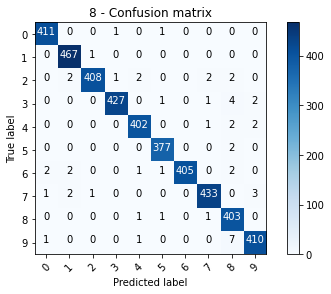

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37376/37804 [============================>.] - ETA: 0s - loss: 4.8831 - acc: 0.9418
Epoch 00001: val_loss improved from inf to 22.00225, saving model to img_classifier_model_9_ResNet50_epoch10.h5
37804/37804 [==============================] - 25s 660us/sample - loss: 4.8758 - acc: 0.9422 - val_loss: 22.0022 - val_acc: 0.2305
Epoch 2/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.8173 - acc: 0.9920
Epoch 00002: val_loss improved from 22.00225 to 3.72541, saving model to img_classifier_model_9_ResNet50_epoch10.h5
37804/37804 [==============================] - 14s 368us/sample - loss: 3.8137 - acc: 0.9920 - val_loss: 3.7254 - val_acc: 0.9218
Epoch 3/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.2193 - acc: 0.9988
Epoch 00003: val_loss improved from 3.72541 to 3.04070, saving model to img_classifier_model_9_ResNet50_epoch10.h5
37804/37804 [==============================] 

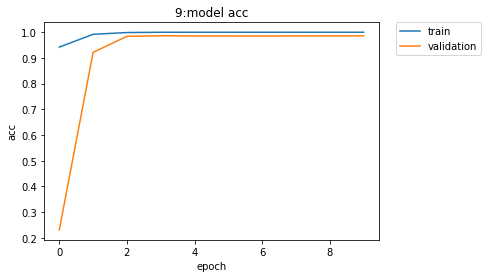

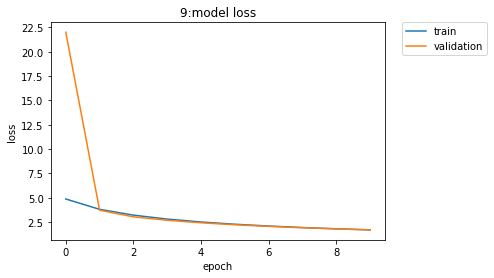

Done compiling best model.


9. Accuracy on validation data: 0.985939
Classification Report
              precision    recall  f1-score   support

           0    0.98561   0.99516   0.99036       413
           1    0.99359   0.99359   0.99359       468
           2    0.98786   0.97602   0.98191       417
           3    0.99766   0.98161   0.98957       435
           4    0.98280   0.98280   0.98280       407
           5    0.99731   0.97889   0.98802       379
           6    0.99036   0.99516   0.99275       413
           7    0.98861   0.98636   0.98749       440
           8    0.95283   0.99507   0.97349       406
           9    0.98309   0.97368   0.97837       418

   micro avg    0.98594   0.98594   0.98594      4196
   macro avg    0.98597   0.98583   0.98583      4196
weighted avg    0.98612   0.98594   0.98596      4196
 samples avg    0.98594   0.98594   0.98594      4196





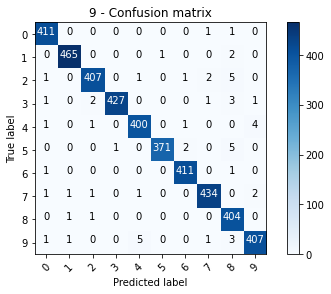

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37376/37804 [============================>.] - ETA: 0s - loss: 4.8883 - acc: 0.9429
Epoch 00001: val_loss improved from inf to 7.45126, saving model to img_classifier_model_10_ResNet50_epoch10.h5
37804/37804 [==============================] - 22s 593us/sample - loss: 4.8813 - acc: 0.9432 - val_loss: 7.4513 - val_acc: 0.5777
Epoch 2/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.8450 - acc: 0.9922
Epoch 00002: val_loss improved from 7.45126 to 3.59215, saving model to img_classifier_model_10_ResNet50_epoch10.h5
37804/37804 [==============================] - 14s 368us/sample - loss: 3.8412 - acc: 0.9922 - val_loss: 3.5922 - val_acc: 0.9702
Epoch 3/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.2521 - acc: 0.9987
Epoch 00003: val_loss improved from 3.59215 to 3.07277, saving model to img_classifier_model_10_ResNet50_epoch10.h5
37804/37804 [==============================]

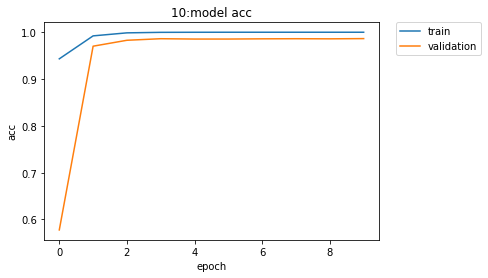

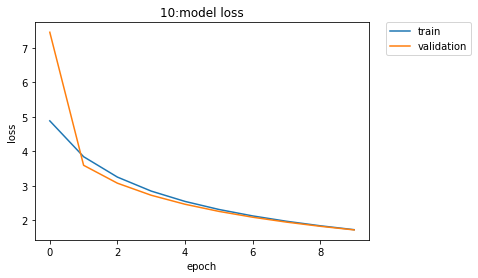

Done compiling best model.


10. Accuracy on validation data: 0.986416
Classification Report
              precision    recall  f1-score   support

           0    0.99515   0.99274   0.99394       413
           1    0.98723   0.99145   0.98934       468
           2    0.98341   0.99520   0.98927       417
           3    0.98837   0.97701   0.98266       435
           4    0.99002   0.97543   0.98267       407
           5    0.98425   0.98945   0.98684       379
           6    0.99517   0.99758   0.99637       413
           7    0.97955   0.97955   0.97955       440
           8    0.98762   0.98276   0.98519       406
           9    0.97393   0.98325   0.97857       418

   micro avg    0.98642   0.98642   0.98642      4196
   macro avg    0.98647   0.98644   0.98644      4196
weighted avg    0.98644   0.98642   0.98641      4196
 samples avg    0.98642   0.98642   0.98642      4196





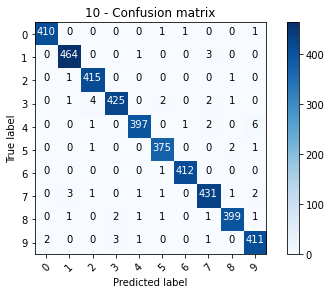

In [9]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    #history_file = 'img_classifier_history_%s_%s.json' %(i+1, model_name)
    
    # 学習率をエポックごとに減少
    class LearningRateTracker(Callback):
        def on_epoch_end(self, epoch, logs={}):
            optimizer = self.model.optimizer

            _lr = tf.to_float(optimizer.lr, name='ToFloat')
            _decay = tf.to_float(optimizer.decay, name='ToFloat')
            _iter = tf.to_float(optimizer.iterations, name='ToFloat')

            lr = K.eval(_lr * (1. / (1. + _decay * _iter)))
            #lr = K.eval(tf.to_float(optimizer.lr, name='ToFloat'))
            print('\nLR: {:.6f}\n'.format(lr))
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
        # 学習率の減衰
        #lr_tracker = LearningRateTracker()

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # historyファイルの保存
    #with open(history_file,  "w", encoding="utf8") as history_json_file:
    #    json.dump(history.history, history_json_file)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if len(itr) == 1:
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on test data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(i)]["precision"]
        recall_list[i,j] = other_score[str(i)]["recall"]
        fscore_list[i,j] = other_score[str(i)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
# 
#clear_output()

# move h5 file
for i in glob.glob("*model*"+model_name+"*"+"h5"):
    shutil.move(i, model_dir)

# remove remaining file
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.985405
Classification Report
              precision    recall  f1-score   support

           0    0.98797   0.99347   0.99071      4132
           1    0.98833   0.99402   0.99117      4684
           2    0.98511   0.98228   0.98370      4177
           3    0.98818   0.98000   0.98408      4351
           4    0.98622   0.98428   0.98525      4072
           5    0.98807   0.98208   0.98507      3795
           6    0.99271   0.98743   0.99006      4137
           7    0.98368   0.98614   0.98491      4401
           8    0.97324   0.98449   0.97883      4063
           9    0.98039   0.97875   0.97957      4188

   micro avg    0.98540   0.98540   0.98540     42000
   macro avg    0.98539   0.98530   0.98533     42000
weighted avg    0.98542   0.98540   0.98541     42000
 samples avg    0.98540   0.98540   0.98540     42000





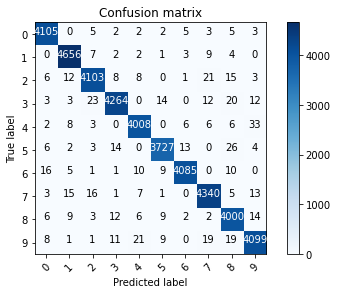

In [10]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるための整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 22s 515us/sample - loss: 4.8184 - acc: 0.9477
Epoch 2/10
42000/42000 [==============================] - 14s 328us/sample - loss: 3.7746 - acc: 0.9855
Epoch 3/10
42000/42000 [==============================] - 14s 328us/sample - loss: 3.1917 - acc: 0.9970
Epoch 4/10
42000/42000 [==============================] - 14s 337us/sample - loss: 2.8040 - acc: 0.9997
Epoch 5/10
42000/42000 [==============================] - 14s 332us/sample - loss: 2.5211 - acc: 1.0000
Epoch 6/10
42000/42000 [==============================] - 14s 332us/sample - loss: 2.3016 - acc: 1.0000
Epoch 7/10
42000/42000 [==============================] - 14s 333us/sample - loss: 2.1249 - acc: 1.0000
Epoch 8/10
42000/42000 [==============================] - 15s 347us/sample - loss: 1.9971 - acc: 0.9972
Epoch 9/10
42000/42000 [==============================] - 14s 338us/sample - loss: 1.8817 - acc: 0.9984
Epoch 10/10
42000/42000 [================

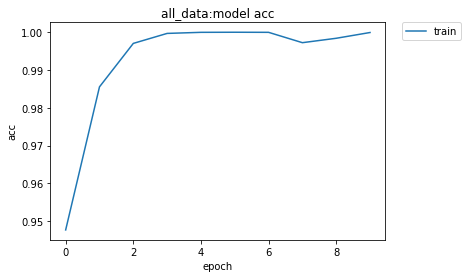

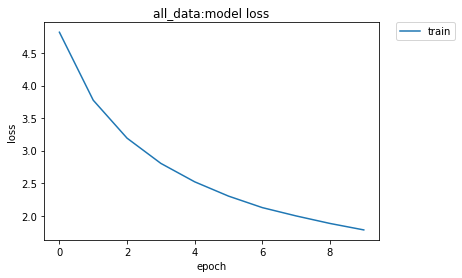

In [17]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 512 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数

# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [21]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result.csv", index = False)

In [16]:
# モデルの削除
clear_session()
del ResNetModel, history
gc.collect()

4354